<a href="https://colab.research.google.com/github/wisdomscode/AI-Lab-Deep-Learning-PyTorch/blob/main/AI_Lab_Project_4_5_Celebrity_Sighting_In_India_Making_a_Web_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Summary**:

In this lesson, we'll create a web app to run our face recognition utility. This will create a tool that anyone can upload a file to. The app will give them back an image with the faces outlined and labeled, at least for faces that it knows about. To build this tool, we'll need to work outside the notebook using a tool called Flask. Flask will set up a small web server running the app we'll create, that we'll be able to access like any web page.

**Objectives**:

Make a series of functions we can call to do face recognition
Create a py file so our app can use those functions
Assemble a Flask app as a front-end to our face recognizer
Test the app

**New Terms:**

* Modular
* Web app
* Route


### Getting Ready

We'll be developing the face recognition tools we need in the notebook before transferring them to a separate file for our app. Let's import what we'll need.

In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image

Since we'll be doing face detection and identification, we'll need both `MTCNN` and `InceptionResnet`. We'll use the settings from the previous lesson for `MTCNN`: `image_size=240`, `min_face_size=40`. Since we'll be identifying all faces in the image, use `keep_all=True`.

To be safe, we'll also set `InceptionResnet` to `eval` mode.

**Task 4.5.1:** Load `MTCNN` and `InceptionResnet`. Use the `vggface2` weights for `InceptionResnet`.

In [ ]:

mtcnn = MTCNN(image_size=240, min_face_size=40, keep_all=True)
resnet = InceptionResnetV1(pretrained="vggface2")

resnet = resnet.eval()

print(f"MTCNN image size: {mtcnn.image_size}")
print(f"MTCNN keeping all faces: {mtcnn.keep_all}")
print(f"InceptionResnet weight set: {resnet.pretrained}")

#output
MTCNN image size: 240
MTCNN keeping all faces: True
InceptionResnet weight set: vggface2

We'll also need the library of known faces we created in the previous lesson.

**Task 4.5.2:** Load the `embeddings.pt` file with `torch`.

In [ ]:
embedding_data = torch.load("embeddings.pt")

print(f"Known names: {[data[1] for data in embedding_data]}")

#output
Known names: ['mary_kom', 'ranveer']


We'll be getting images uploaded to our app, rather than reading from disk. But we'll need to test things as we go, so let's get a few sample images.

**Task 4.5.3:** Create a variable to access the extracted frames in `project4/data/extracted_frames`. Use `pathlib`.

In [ ]:
project_dir = Path("project4")
images_dir = project_dir / "data" / "extracted_frames"

print(images_dir)

#output
project4/data/extracted_frames


Here are two sample images to test as we go.

In [ ]:
sample_single = Image.open(images_dir / "frame_10.jpg")
sample_multiple = Image.open(images_dir / "frame_1280.jpg")

In [ ]:
sample_single

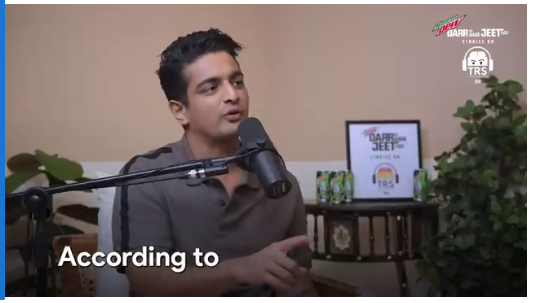

In [ ]:
sample_multiple

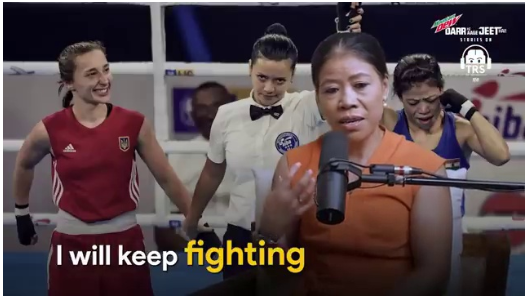

### Face Recognition

Our app will be taking in images, detecting the faces in them, and returning an output with the faces highlighted and labeled. This is the same thing we did in the previous notebook.

This consists of several steps:
- Detect if there any faces and get the bounding boxes and probabilities
- Get the cropped images for those faces
- Only work on the faces with high probability of being a face
- Get the embeddings for those faces
- Find the distances from those embeddings to the ones in our library
- Select the correct label (or "Undetected" if none match)
- Draw the bounding boxes and labels on the images

We'll be more _modular_ this time. This means we'll break the code into small pieces, each doing a specific task. We'll do our steps as separate functions, then put them together at the end.

### Locating Faces

Let's start with the first two steps. These involve running `mtcnn.detect` to get the bounding boxes, and `mtcnn` directly (with the `return_prob=True` argument) to get the cropped images and probabilities. We've reformatted the output a bit to make things easier later.

**Task 4.5.4:** Run `mtcnn` to get the cropped images and probabilities, and the bounding boxes in the function below.

In [ ]:
def locate_faces(image):
    cropped_images, probs = mtcnn(image, return_prob=True)
    boxes, _ = mtcnn.detect(image)

    if boxes is None or cropped_images is None:
        return []
    else:
        return list(zip(boxes, probs, cropped_images))

We'll do a test run on the `sample_multiple` with Mary with a picture of her boxing victory in the background. We're saving the list of detected faces that come out to `multiple_faces`, which we'll use for later tests as well. Note that there are actually five faces here - there's someone in the background behind the referee.

In [ ]:
multiple_faces = locate_faces(sample_multiple)
print(f"How many faces in the sample with 5 faces: {len(multiple_faces)}")

#output
How many faces in the sample with 5 faces: 5


Instead of returning three lists, we're now returning one list. Each element in the list corresponds to one face. Each of those faces has three pieces of information, in the order: bounding box, probabilities, cropped image. Let's look at the first one.

In [ ]:
face = multiple_faces[0]
print(f"First bounding box: {face[0]}")
print(f"First probability: {face[1]}")
print(f"Shape of first cropped image: {face[2].shape}")

#output
First bounding box: [385.89849853515625 64.89743041992188 466.6402282714844 171.38978576660156]
First probability: 0.9995344877243042
Shape of first cropped image: torch.Size([3, 240, 240])

Looks like it's definitely a face. Why did we reorganize this? Now we can build a function that only worries about one face, then loop over it.

### Determining Names

For the moment, we'll skip the step about filtering out low probability faces and come back to it. Then next steps after that are to get the embedding for our face, and compare it to the known faces. We'll want to get back both the name (if we know it) and the distance.

**Task 4.5.5:** Fill in the missing parts of this function.

In [ ]:
def determine_name_dist(cropped_image, threshold=0.9):
    # Use `resnet` on `cropped_image` to get the embedding.
    # Don't forget to unsqueeze!
    emb = resnet(cropped_image.unsqueeze(0))

    # We'll compute the distance to each known embedding
    distances = []
    for known_emb, name in embedding_data:
        # Use torch.dist to compute the distance between
        # `emb` and the known embedding `known_emb`
        dist = torch.dist(emb, known_emb).item()
        distances.append((dist, name))

    # Find the name corresponding to the smallest distance
    dist, closest = min(distances)

    # If the distance is less than the threshold, set name to closest
    # otherwise set name to "Undetected"
    if dist < threshold:
        name = closest
    else:
        name = "Undetected"

    return name, dist

And to see if it worked, let's run it on our faces. We expect two of these to be Mary, the rest are people we haven't seen before and should come back as `Undetected`.

In [ ]:
print("Who's in the picture with 5 faces, with distances?")
for index, face in enumerate(multiple_faces):
    print(f"{index}: {determine_name_dist(face[2])}")

#output
Who's in the picture with 5 faces, with distances?
0: ('mary_kom', 0.6223787665367126)
1: ('Undetected', 1.036726713180542)
2: ('Undetected', 1.0629839897155762)
3: ('mary_kom', 0.8036866188049316)
4: ('Undetected', 1.1338592767715454)

Great! That's what we expected. Now we need to alter the image to outline the faces and label names.

### Labeling Images

The function below adds the box and label to an _existing_ image. To use it, we'll need to plot our image with `matplotlib`, then call this function in the same cell. We'll be reusing the same structure from the previous lessons, with a little simplification.

**Task 4.5.6:** Fill in the missing portions of this plotting function.

In [ ]:
def label_face(name, dist, box, axis):
    """Adds a box and a label to the axis from matplotlib
    - name and dist are combined to make a label
    - box is the four corners of the bounding box for the face
    - axis is the return from fig.subplots()
    Call this in the same cell as the figure is created"""

    # Add the code to generate a Rectangle for the bounding box
    # set the color to "blue" and fill to False
    rect = plt.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        fill=False,
        color="blue",
    )
    axis.add_patch(rect)

    # Set color to be red if the name is "Undetected"
    # otherwise set it to be blue
    if name == "Undetected":
        color= "red"
    else:
        color="blue"

    label = f"{name} {dist:.2f}"
    axis.text(box[0], box[1], label, fontsize="large", color=color)

To demonstrate how it works, we'll plot the first face found in the multiple faces. The code at the beginning sets `matplotlib` to create an output image the same size as the photo we're working with.

In [ ]:
# This sets the image size
# and draws the original image
width, height = sample_multiple.size
dpi = 96
fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
axis = fig.subplots()
axis.imshow(sample_multiple)
plt.axis("off")

face = multiple_faces[0]
cropped_image = face[2]
box = face[0]

name, dist = determine_name_dist(cropped_image)

label_face(name, dist, box, axis)

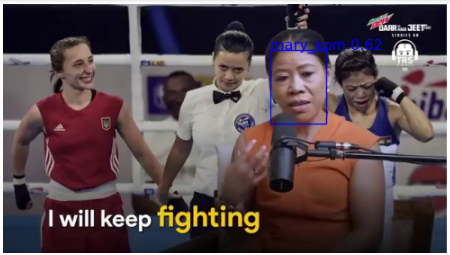

Now we can run this in a loop on each face.

**Task 4.5.7:** Fill in the needed loop to go over the faces in `multiple_faces`.

In [ ]:
# This sets the image size
# and draws the original image
width, height = sample_multiple.size
dpi = 96
fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
axis = fig.subplots()
axis.imshow(sample_multiple)
plt.axis("off")

for face in multiple_faces:
    box, prob, cropped_image = face

    name, dist = determine_name_dist(cropped_image)

    label_face(name, dist, box, axis)

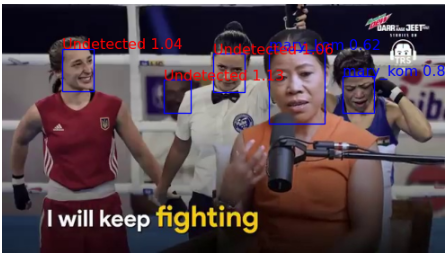

Great! We've got a function we can call to add the boxes and labels to an image. This will make our later code easier to understand.

### Putting it together

We have all of our pieces. Let's put them all together into one function we can call on an image. This code will look more streamlined than previous lessons, since we'll be calling functions rather than writing out all the code. This is a big benefit of the modular approach, it makes it clearer what we're doing. The details are separated out into the functions.

**Task 4.5.8:** Fill in the missing pieces to put our functions together into a larger whole.

In [ ]:
def add_labels_to_image(image):
    # This sets the image size
    # and draws the original image
    width, height = image.width, image.height
    dpi = 96
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    axis = fig.subplots()
    axis.imshow(image)
    plt.axis("off")

    # Use the function locate_faces to get the individual face info
    faces = locate_faces(image)

    for box, prob, cropped in faces:
        # If the probability is less than 0.90,
        # It's not a face, skip this run of the loop with continue
        if prob < 0.9:
            continue

        # Call determine_name_dist to get the name and distance
        name, dist = determine_name_dist(cropped)

        # Use label_face to draw the box and label on this face
        label_face(name, dist, box, axis)

    return fig

We can test this by running it on our `sample_multiple` (the original image).

In [ ]:
labeled_multiple = add_labels_to_image(sample_multiple)

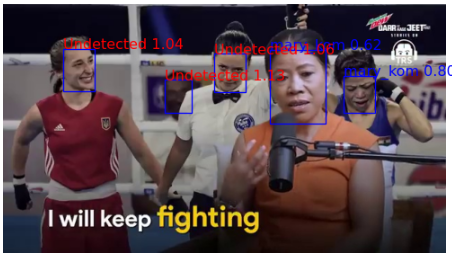

<div class="alert alert-info" role="alert">
You may find it odd that we saved the result to a variable, but the image was still displayed. This is something that happens in Jupyter. If we were running this from other Python utilities, the image would only be displayed when we ask. If we hadn't saved the result to a variable, the image would actually have been displayed twice here! That's because one way to display it, in Jupyter, is to have the image variable as the last line in a cell. This is also why we need to be sure to run all of our code to alter the image in the same cell, as Jupyter will try to display the image at the end of the cell.
</div>

Let's also test this on our other image, it should correctly identify the interviewer.

In [ ]:
**Task 4.5.9:** Call our `add_labels_to_image` function on `sample_single` and save the result to `labeled_single`.

In [ ]:
labeled_single = add_labels_to_image(sample_single)

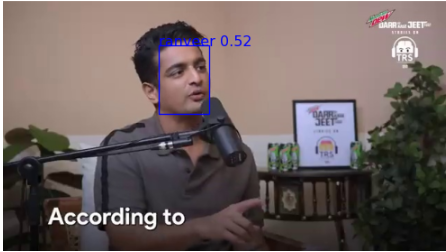

We're in good shape! Now we can run our whole face recognition process with a single function call on our image. We're ready to start building our app.

### Moving to a File

Our app won't be able to see what's in our notebook. We'll need to move our code to a `py` file. We won't need to alter it, it's ready to go as-is. The `face_recognition.py` has slots for all the things we'll need. Thankfully, we don't need everything. What we do need is:

- The imports
- Creating our `mtcnn` and `resnet`
- Reading the `embedding_data` from a file (our known faces)
- The `locate_faces` function
- The `determine_name_dist` function
- The `label_face` function
- The `add_labels_to_image` function


**Task 4.5.10:** Fill in the `face_recognition.py` file.


We'll test that it worked by importing it and running it. If this works, we're done with the face recognition!

In [ ]:
# **AI Lab: Deep Learning for Computer Vision**
# **WorldQuant University**
#
#

# **Usage Guidelines**
#
# This file is licensed under Creative Commons Attribution-NonCommercial-
# NoDerivatives 4.0 International.
#
# You **can** :
#
#   * ✓ Download this file
#   * ✓ Post this file in public repositories
#
# You **must always** :
#
#   * ✓ Give credit to WorldQuant University for the creation of this file
#   * ✓ Provide a link to the license
#
# You **cannot** :
#
#   * ✗ Create derivatives or adaptations of this file
#   * ✗ Use this file for commercial purposes
#
# Failure to follow these guidelines is a violation of your terms of service and
# could lead to your expulsion from WorldQuant University and the revocation
# your certificate.
#
#

# Import needed libraries
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image

# Load MTCNN, Resnet, and the embedding data

mtcnn = MTCNN(image_size=240, min_face_size=40, keep_all=True)

resnet = InceptionResnetV1(pretrained="vggface2")
embedding_data = torch.load("embeddings.pt")

resnet = resnet.eval()


# Fill in the locate_face function
def locate_faces(image):
    cropped_images, probs = mtcnn(image, return_prob=True)
    boxes, _ = mtcnn.detect(image)

    if boxes is None or cropped_images is None:
        return []
    else:
        return list(zip(boxes, probs, cropped_images))



# Fill in the determine_name_dist function
def determine_name_dist(cropped_image, threshold=0.9):
    # Use `resnet` on `cropped_image` to get the embedding.
    # Don't forget to unsqueeze!
    emb = resnet(cropped_image.unsqueeze(0))

    # We'll compute the distance to each known embedding
    distances = []
    for known_emb, name in embedding_data:
        # Use torch.dist to compute the distance between
        # `emb` and the known embedding `known_emb`
        dist = torch.dist(emb, known_emb).item()
        distances.append((dist, name))

    # Find the name corresponding to the smallest distance
    dist, closest = min(distances)

    # If the distance is less than the threshold, set name to closest
    # otherwise set name to "Undetected"
    if dist < threshold:
        name = closest
    else:
        name = "Undetected"

    return name, dist



# Fill in the label_face function
def label_face(name, dist, box, axis):
    """Adds a box and a label to the axis from matplotlib
    - name and dist are combined to make a label
    - box is the four corners of the bounding box for the face
    - axis is the return from fig.subplots()
    Call this in the same cell as the figure is created"""

    # Add the code to generate a Rectangle for the bounding box
    # set the color to "blue" and fill to False
    rect = plt.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        fill=False,
        color="blue",
    )
    axis.add_patch(rect)

    # Set color to be red if the name is "Undetected"
    # otherwise set it to be blue
    if name == "Undetected":
        color= "red"
    else:
        color="blue"

    label = f"{name} {dist:.2f}"
    axis.text(box[0], box[1], label, fontsize="large", color=color)



# Fill in the add_labels_to_image function
def add_labels_to_image(image):
    # This sets the image size
    # and draws the original image
    width, height = image.width, image.height
    dpi = 96
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    axis = fig.subplots()
    axis.imshow(image)
    plt.axis("off")

    # Use the function locate_faces to get the individual face info
    faces = locate_faces(image)

    for box, prob, cropped in faces:
        # If the probability is less than 0.90,
        # It's not a face, skip this run of the loop with continue
        if prob < 0.9:
            continue

        # Call determine_name_dist to get the name and distance
        name, dist = determine_name_dist(cropped)

        # Use label_face to draw the box and label on this face
        label_face(name, dist, box, axis)

    return fig


# This file © 2024 by WorldQuant University is licensed under CC BY-NC-ND 4.0.


The above code is saved in a python file called `face_recognition.py` which we will import to work with

In [ ]:
import face_recognition

In [ ]:
test_multiple = face_recognition.add_labels_to_image(sample_multiple)

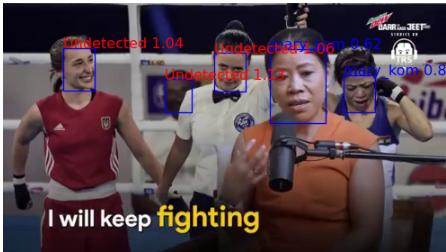

### Flask Application

Not everyone can run the Python functions we created. We'll make this something anyone can use by building a web application using Flask. Once it's running, we'll have a web site that is very user friendly and runs our code behind the scenes.

Our Flask application will have three files:
- The `face_recognition.py` we just created, that has our logic
- `app.py`, the main application that will handle interaction
- `upload.html`, a web page to display to users

The `upload.html` already exists for us, it's in the `templates` directory. It creates an interface web page with two buttons, one to select which image to run on, and one to upload the file to be processed.

Let's build up the `app.py` so our users can interact with our code without knowing Python.

### Home Page

The first thing we'll do is make our interface page available. We'll worry about adding in our face recognition code in the next section.

In Flask, we create a function to tell it what to display. That's already done in `app.py`, it's the `home` function. It prepares the HTML from `upload.html` for us and returns that. Our user will see what the function returns. But we need to tell Flask what part of our website will run that code. We do that by setting a _route_.

We want to send someone that comes to our app directly to that page, so we'll direct the `"/"`  endpoint to go to our `home` function. We do this by adding

```python
@app.route("/")
```

on the line _before_ we define our function. This is called a decorator.

In [ ]:
# app.py

# **AI Lab: Deep Learning for Computer Vision**
# **WorldQuant University**
#
#

# **Usage Guidelines**
#
# This file is licensed under Creative Commons Attribution-NonCommercial-
# NoDerivatives 4.0 International.
#
# You **can** :
#
#   * ✓ Download this file
#   * ✓ Post this file in public repositories
#
# You **must always** :
#
#   * ✓ Give credit to WorldQuant University for the creation of this file
#   * ✓ Provide a link to the license
#
# You **cannot** :
#
#   * ✗ Create derivatives or adaptations of this file
#   * ✗ Use this file for commercial purposes
#
# Failure to follow these guidelines is a violation of your terms of service and
# could lead to your expulsion from WorldQuant University and the revocation
# your certificate.
#
#

import io


from flask import Flask, render_template, request, send_file
from PIL import Image

# Import our face recognition code

# Starts Flask
app = Flask(__name__)


# Set the route to "/"
@app.route("/")
def home():
    return render_template("upload.html")


@app.route("/recognize", methods=["POST"])
def process_image():
    # Display an error message if no image found
    if "image" not in request.files:
        return "No image provided", 400

    # Get the file sent along with the request
    file = request.files["image"]

    # Video also shows up as an image
    # we want to reject those as well
    if not file.mimetype.startswith("image/"):
        return "Image format not recognized", 400

    image_data = file.stream

    # Run our face recognition code!
    img_out = run_face_recognition(image_data)

    if img_out == Ellipsis:
        return "Image processing not enabled", 200
    else:
        # Our function returns something from matplotlib,
        # convert it to a web-friendly form and return it
        out_stream = matplotlib_to_bytes(img_out)
        return send_file(out_stream, mimetype="image/jpeg")


def run_face_recognition(image_data):
    # Open image_data with PIL
    input_image = ...

    # Run our function on the PIL image
    img_out = ...

    return img_out


def matplotlib_to_bytes(figure):
    buffer = io.BytesIO()
    figure.savefig(buffer, format="jpg", bbox_inches="tight")
    buffer.seek(0)
    return buffer


if __name__ == "__main__":
    app.run(debug=True)


# This file © 2024 by WorldQuant University is licensed under CC BY-NC-ND 4.0.


**Task 4.5.11:** Add the route decorator to the line before we define the `home` function in `app.py`. Make sure you save the file!

We can now look at our app! The face recognition isn't connected yet, so that part won't work. But we can see what it looks like.

To run it, use the Launcher (the plus button next to the notebook tabs) and start a terminal. **Make sure you're in the directory with the `app.py` file** - you can check by running `ls`, you should see `app.py` in the list of things. If not, use `cd` to change to the right directory.

Now we can run our app by typing this in the terminal (you can cut and paste):

```bash
gunicorn --bind 0.0.0.0:8000 app:app
```

**Task 4.5.12:** Start the app running in your terminal!

After a few moments, you should see messages in the terminal about booting workers. That means it's up and running.

Let's look at it and see what we've got. `gunicorn` has started a web server running, which we can access as regular web page!

To preview our page, we'll need to switch to the `Flask Website` view on the top tabs. Here's a quick summary of the steps to follow:

![Switch View example](images/switch-view.png)

If you submit an image using the "Upload and analyze" button, you can get back to the main page by pressing back on your browser.

**Task 4.5.13:** Go to your app page and see what it looks like. Try to play with it! It works best with `jpg` images.

When you're done, shut off `gunicorn`. You can do this by going back to the terminal and pressing `ctrl-c` (the `ctrl` button and the `c` button at the same time). You have to be in the terminal for this to work, and you should see your prompt come back after a message about shutting down.

### Connecting the Face Recognition

The app shows our homepage, but the "Upload and analyze" button doesn't do what we want. We need to hook it up to our face recognition code.

You can open the `upload.html` file to see what's in it by right clicking on it in the browser, and selecting "Open With" then "Editor". It's an HTML file describing a web site with a form. The part we care about is the first line of the form:

```html
<form action="recognize" method="post" enctype="multipart/form-data">
```

This says it's going to send a POST request to the `recognize` endpoint. Another function in `app.py`, named `process_image`, already has the decorator for this. Anything going to `recognize` will get routed to that function. In this case, the function will get a request containing our image.

Let's hook this function up to the code in our `face_recognition.py` file. First order of business is to import it. There's a comment near the top of the file where we should import it.

**Task 4.5.14:** In the `app.py` file, import the `add_labels_to_image` from `face_recognition`. You don't need to include the `.py`, Python knows to look for that.

In [ ]:
# add this in the app.py
from face_recognition import add_labels_to_image

In [ ]:
import app

In [ ]:
assert hasattr(app, "add_labels_to_image"), "import not successful"

We'll run some code in the notebook to check that things are working as expected. The behavior of our app hasn't changed yet, but this code will check that our changes are coming along correctly. If you don't get an error, things are working as expected.

Continuing our practice of modular code, the `process_image` function handles input and output. It will read in the image, extract the image data (as `image_data`), then pass it to a function called `run_face_recognition`. This is where we hook in our code. `process_image` then takes the output `matplotlib` image and turns it into something web friendly.

`run_face_recognition` will get `image_data`, the raw binary of the image file. Our function is expecting a `PIL` image, which isn't what we get in `image_data`. Thankfully, we can call `Image.open` directly on the `image_data`, as if it were a filename. Then we need to call our `add_labels_to_image` function on that. There are already lines marked for this in the `run_face_recognition` function, we need to fill them in.

**Task 4.5.15:** Fill in the code to open the image with `PIL` and run our `add_labels_to_image` function, in the `run_face_recognition` function in `app.py`.

In [ ]:
# **AI Lab: Deep Learning for Computer Vision**
# **WorldQuant University**
#
#

# **Usage Guidelines**
#
# This file is licensed under Creative Commons Attribution-NonCommercial-
# NoDerivatives 4.0 International.
#
# You **can** :
#
#   * ✓ Download this file
#   * ✓ Post this file in public repositories
#
# You **must always** :
#
#   * ✓ Give credit to WorldQuant University for the creation of this file
#   * ✓ Provide a link to the license
#
# You **cannot** :
#
#   * ✗ Create derivatives or adaptations of this file
#   * ✗ Use this file for commercial purposes
#
# Failure to follow these guidelines is a violation of your terms of service and
# could lead to your expulsion from WorldQuant University and the revocation
# your certificate.
#
#

import io


from flask import Flask, render_template, request, send_file
from PIL import Image

# Import our face recognition code
from face_recognition import add_labels_to_image

# Starts Flask
app = Flask(__name__)


# Set the route to "/"
@app.route("/")
def home():
    return render_template("upload.html")


@app.route("/recognize", methods=["POST"])
def process_image():
    # Display an error message if no image found
    if "image" not in request.files:
        return "No image provided", 400

    # Get the file sent along with the request
    file = request.files["image"]

    # Video also shows up as an image
    # we want to reject those as well
    if not file.mimetype.startswith("image/"):
        return "Image format not recognized", 400

    image_data = file.stream

    # Run our face recognition code!
    img_out = run_face_recognition(image_data)

    if img_out == Ellipsis:
        return "Image processing not enabled", 200
    else:
        # Our function returns something from matplotlib,
        # convert it to a web-friendly form and return it
        out_stream = matplotlib_to_bytes(img_out)
        return send_file(out_stream, mimetype="image/jpeg")


def run_face_recognition(image_data):
    # Open image_data with PIL
    input_image = Image.open(image_data)

    # Run our function on the PIL image
    img_out = add_labels_to_image(input_image)

    return img_out


def matplotlib_to_bytes(figure):
    buffer = io.BytesIO()
    figure.savefig(buffer, format="jpg", bbox_inches="tight")
    buffer.seek(0)
    return buffer


if __name__ == "__main__":
    app.run(debug=True)


# This file © 2024 by WorldQuant University is licensed under CC BY-NC-ND 4.0.


In [ ]:
# Tests if the image processing worked
# you'll get an error if it didn't
f = open("project4/data/images/mary_kom/frame_115.jpg", "rb")
res = app.run_face_recognition(f)
f.close()

assert isinstance(res, matplotlib.figure.Figure), "Image did not process"

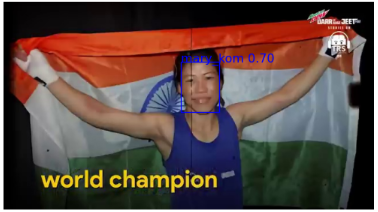

**Task 4.5.16:** Start `gunicorn`, the same way we did before, and open the page for our app again.

In [ ]:
# Go to the terminal, start gunicorn and check activity on the left panel